# DGR analysis
## Efficient generation of context-dependent diversity in living cells
Jonathan L. Schmid-Burgk, David Li, Guilhem Faure, Suchita P. Nety, Jonathan Strecker, Amy X. Guo, Julia Reinhardt, Balwina Koopal, Han Altae-Tran, Feng Zhang

# Table of contents
1. [Import packages](#import)
2. [Input data](#input)
3. [Evaluate functions](#functions)
4. [Overall diversification patterns of wild type system-10](#div)
5. [Contextual base diversification in system-10 wild-type and mutant RTs](#context)
6. [Amino acid distributions in diversified codons](#aa)

Notes:\
If the output of a function involves nucleotides, the frame is specified as either 1 (TR RNA) or -1 (cDNA). See Fig 2h for a schematic.\
J900 files include VR reads.\
J902 files include cDNA reads.\
Input fasta files must consist of pre-trimmed and aligned NGS reads (see Methods).

Suchita Nety\
suchita@mit.edu\
Last updated 9/26/2020

## Import packages <a name="import"></a>

In [1]:
import os
import re
import numpy as np
np.set_printoptions(suppress=True)
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from Bio.Seq import Seq
from Bio import SeqIO
from Bio import pairwise2
from Bio import Align
from Bio.SeqRecord import SeqRecord
import logomaker # optional

## Parameters & data <a name="input"></a>
Do not alter if using provided sample data

In [2]:
# all functions output data in a specified order of bases to keep everything consistent
order = ['A','C','G','T']
order_rc = [str(Seq(letter).reverse_complement()) for letter in order]

# 2-nucleotide motifs in order
order_x2 = [i+j for i in order for j in order]

In [3]:
## define template sequences

# J900 wild type VR amplicon
J900_vr = Seq("GCGCCTGCCGTTCCGTGGTGGCTACTGGAGCGACGCCTCGGATGCGGGGTTGTCGGCGTTGCGCTTGTACAACGCCCGCGGCGATCGCAGCAG"\
              "CTTCATCGGTTGCCGGCCTGCTTTT")

# J900 wild type TR div sequence as if it were in the VR amplicon
J900_tr = Seq("GCGCCTGCCGATCCGTGGTGGCAACTGGAACAACGCCTCGGATGCGGGGTTGTCGGCGTTGAACTTGAACAACGCCCGCGGCAATCGCAACAG"\
              "CAACATCGGTTGCCGGCCTGCTTTT")

# full J902 cDNA amplicon (120nt)
J902 = Seq("TGGCAACTGGAACAACGCCTCGGATGCGGGGTTGTCGTCGACGTTTTCTTGGGTCTACCGTTTAATGTCGAC"\
           "GGCGTTGAACTTGAACAACGCCCGCGGCAATCGCAACAGCAACATCGG")

In [4]:
## find relevant positions in the diversified region to use as "template" arguments in later functions

## templated by the TR
# A(AC)
aac1_J900tr_idx = [m.start() for m in re.finditer('AAC',str(J900_tr))]
aac_J900tr_idx = [aac1_J900tr_idx, [val + 1 for val in aac1_J900tr_idx], [val + 2 for val in aac1_J900tr_idx]]
# A positions templated by the TR
a_J900tr_idx = [m.start() for m in re.finditer('A',str(J900_tr))]
# nonA positions templated by the TR
nona_J900tr_idx = list(set(np.arange(len(J900_tr))) - set(a_J900tr_idx))

## positions in the cDNA
aac1_J902_idx = [m.start() for m in re.finditer('AAC',str(J902))]
aac2_J902_idx = [val + 1 for val in aac1_J902_idx]
aac_J902_idx = [aac1_J902_idx, [val + 1 for val in aac1_J902_idx], [val + 2 for val in aac1_J902_idx]]
aa_J902_idx = [m.start() for m in re.finditer('AA',str(J902))]
a_J902_idx = [m.start() for m in re.finditer('A',str(J902))]

# exclude the first 4 and last 4 bases bc these are contained in hom
nona_J902_idx = list(set(np.arange(4,len(J902)-4)) - set(a_J902_idx))

## Execute functions<a name="functions"></a>
Do not alter

In [5]:
# For all the reads in a sample, count number of mismatches to a specified sequence. 
# Returns a list of # of mismatches per read (reads = False)
# or
# returns list of read sequence with a specified number of mismatches to a template amplicon (reads = True)

# filename = fasta without extension
# input fasta file must have perfectly aligned reads
# template = any amplicon defined above
# n = at least n mismatches will be counted in the final list. Only relevant if reads = True.
# reads = False to output a list of counts, True to output a list of read sequences

def count_or_filter_mm(filename, template, n = 0, reads = False):
    
    output = []
    
    for seq_record in SeqIO.parse(filename+'.fasta', "fasta"):
        
        aligner = Align.PairwiseAligner()
        
        # number of mismatches
        n_mm = int(aligner.score(template, template) - aligner.score(seq_record.seq.ungap("-"), template))
        
        if reads == False:
            output.append(n_mm) # output the number of mismatches
        else:
            if n_mm >= n:
                output.append(seq_record) # output the sequence of the read
    return output

In [6]:
# Tally the frequency of each base OR total mismatches to a specified template at each specified position
# Returns a 4x1 or 4xlen(indices) array where rows are each base in order; or 1x1 or 1xlen(indices) array
# frame = 1

# filename = without extension
# template = any amplicon defined above
# indices = list of index positions in the template of interest
# average = default True to average the frequencies over all the indices
# percent = default True; otherwise False for read counts 

def count_div(filename, template, indices, stacked = True, percent = True, average = False):
    
    if stacked == True:
        counter = np.zeros((4, len(indices)))
    else:
        counter = np.zeros((1, len(indices)))
        totcounter = np.zeros((1, len(indices)))
    
    for seq_record in SeqIO.parse(filename+'.fasta', "fasta"):
        
        # get the sequence
        read = seq_record.seq.ungap("-")
        
        # for position in read
        for idx, posn in enumerate(indices): # idx is the index of the list indices, posn is the actual position
            base = read[posn]
            
            # update counter, exclude N's
            if base != 'N':
                
                # keep track of base frequencies for stacked output
                if stacked == True:
                    counter[order.index(base), indices.index(posn)] += 1
                
                else:
                    totcounter[0, idx] += 1
                    if base != template[posn]: # only keep track of mismatch frequencies for non-stacked output
                        counter[0, idx] += 1
    
    if percent == True:
        if stacked == True:
            for i in range(np.shape(counter)[1]):
                counter[:,i] = 100* counter[:,i] / sum(counter[:,i])
        else:
            counter = 100* counter / totcounter
    
    if average == True:
        # average counter across all indices
        counter_avg = np.zeros((np.shape(counter)[0], 1))
        for i in range(np.shape(counter)[0]):
            counter_avg[i,0] = np.mean(counter[i])
        return counter_avg
    else:
        return counter

In [70]:
# Tally the frequency of each possible 2-base motif at each specified position
# Outputs 4x4 array with counts of each motif. Index base (frame = 1) at rows and index+1 base at columns.

# filename = without extension
# template = cdna or tr
# indices = list of positions in the given template
# mmfilter = 'bmm', '1mm', '2mm' (both, 1st or 2nd base don't match the template)

def count_motif(filename, template, indices, mmfilter = 'all', norm = True):
    
    counter = np.zeros((4, 4))
    
    for seq_record in SeqIO.parse(filename+'.fasta', "fasta"):
        
        # get the sequence of the read
        read = seq_record.seq.ungap("-")
        
        # for each (first) position:
        for idx in indices:
            
            # get the 1st base
            base1 = read[idx]
            # get the 2nd base
            base2 = read[idx+1]
            
            # neither base can be N
            if base1 != 'N' and base2 !='N':
                
                # for any non-N scenario
                if mmfilter == 'all':
                    counter[order.index(base1),order.index(base2)] += 1
                    
                # if either base mismatches the template
                elif mmfilter == 'emm':
                    if base1 != template[idx] or base2 != template[idx+1]:
                        counter[order.index(base1),order.index(base2)] += 1
                
                # if both bases don't match the template
                elif mmfilter == 'bmm':
                    if base1 != template[idx] and base2 != template[idx+1]:
                        counter[order.index(base1),order.index(base2)] += 1
                
                # if base1 doesn't match the template        
                elif mmfilter == '1mm':
                    if base1 != template[idx]:
                        counter[order.index(base1),order.index(base2)] += 1
                
                # if base2 doesn't match the template        
                elif mmfilter == '2mm':
                    if base2 != template[idx]:
                        counter[order.index(base1),order.index(base2)] += 1
       
    if norm == True:
        # normalize base counts by column
        for i in range(np.shape(counter)[1]):
            if sum(counter[:,i]) != 0: # avoid divide by 0 errors
                counter[:,i] = counter[:,i] / sum(counter[:,i])
    
    return counter

In [91]:
# Tally the frequency of each base based on the previous base at each specified position (contextual diversity)
# Outputs tidy dataframe. 
# All base labels are frame = -1

# filename = without extension
# template = cdna or tr
# indices = list of positions in the given template (for this analysis only template A indices make sense)

def count_context(filename, template, indices):

    output = pd.DataFrame(columns = ['reads', '%', 
                                     'base', 'read preceding base', 'templated preceding base', 'match','idx'])
    
    # for each position in the template (each AA unit):
    for idx in indices:
        
        # count all 2-AA motifs at this position
        counter_ct = count_motif(filename, template, [idx], mmfilter = 'all', norm = False)
        counter_pct = count_motif(filename, template, [idx], mmfilter = 'all', norm = True)
        
        
        # store in df by rolling through each of the 16 possible motifs
        for i, motif in enumerate(order_x2):
            to_append = pd.DataFrame([[int(list(counter_ct.flatten())[i]), 
                                       100*list(counter_pct.flatten())[i], 
                                       str(Seq(motif[0]).reverse_complement()), 
                                       str(Seq(motif[1]).reverse_complement()), 
                                       str(Seq(template[idx+1]).reverse_complement()),
                                       template[idx+1] == motif[1], idx]], 
                                     columns = output.columns)

            output = output.append(to_append, ignore_index=True)
    
    return output

In [9]:
# Count all residues specified by an index list (of all 3 codon positions)

# filename = without extension
# template = cdna or tr
# indices = list of positions of the first base of each codon
# observed = True if we're calculating the amino acid distributions based on the provided data
# observed = False if we're calculating the expected distribution.

# returns a dict with amino acid residue as keys, values as percent, filename, observed/expected

def count_residues(filename, indices, observed = True):
    
    # initialize counter for amino acids
    counter = {x:0 for x in ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', \
                              'R', 'S', 'T', 'V', 'W', 'Y', 'X', '*']}
    
    if observed == True:

        for seq_record in SeqIO.parse(filename+'.fasta', "fasta"):

            # get the sequence of the read
            read = seq_record.seq.ungap("-")

            # for codon where first posn is specified in indices
            for i in range(len(indices[0])):
                residue = read[indices[0][i]:indices[0][i]+3].translate()[0]
                counter[residue] += 1

        # sort, convert to percentage, add a label for filename and obs/exp
        s = sum(counter.values())
        counter = {k: [v*100/s, 
                       filename.upper(), 
                       'Observed'] for k, v in sorted(counter.items(), key=lambda item: item[1], reverse = True)}

    else: 
        # base frequencies at all positions (not percentages)
        basefreq = [count_div(filename, Seq(""), indices[i], stacked = True, percent = True, average = False)
                    /100 for i in range(len(indices))]

        # init codon dict
        codond = dict(zip([b1 + b2 + b3 for b1 in order for b2 in order for b3 in order],
                          [0 for c in range(64)]))

        # collect frequencies of each codon
        for k,v in codond.items():
            
            bases = [order.index(k[0]), order.index(k[1]),order.index(k[2])]
            
            # positionwise: codond[k] = (basefreq[0][bases[0]]*basefreq[1][bases[1]]*basefreq[2][bases[2]])[0]
            # averaged over A's in AAC codons
            basefreq_first2 = (basefreq[0] + basefreq[1])/2
            codond[k] = (basefreq_first2[bases[0]]*basefreq_first2[bases[1]]*basefreq[2][bases[2]])[0]
                
            aa_key = Seq(k).translate()[0]
            counter[aa_key] += codond[k]

        counter = {k: [100*v, 
                       filename.upper(), 
                       'Expected'] for k, v in sorted(counter.items(), key=lambda item: item[1], reverse = True)}
    return counter

## Overall diversification patterns of wild type system-10 <a name="div"></a>
Frame = 1

### Frequency of mismatches to template VR

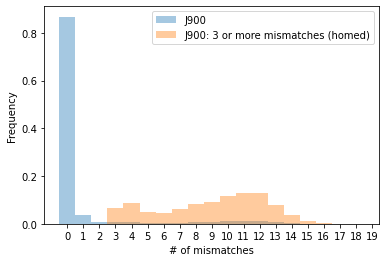

In [40]:
sample = 'sample_data/wt_J900'
data = count_or_filter_mm(sample, J900_vr, n = 0, reads = False)

sns.distplot(data, bins = np.arange(0, 20), norm_hist = True, hist = True, kde = False, 
             label = 'J900')
sns.distplot(list(filter(lambda a: a >= 3, data)), bins = np.arange(0, 20), norm_hist = True, 
             hist = True, kde = False, label = 'J900: 3 or more mismatches (homed)')

plt.xticks(np.arange(0.5, 20.5), np.arange(0, 20))
plt.legend();
plt.xlabel('# of mismatches');
plt.ylabel('Frequency');

In [42]:
# Retrohoming efficiency (defined by % of reads with at least 3 mismatches to VR template)
sample = 'sample_data/wt_J900'
data = count_or_filter_mm(sample, J900_vr, n = 0, reads = False)
print('Retrohoming efficiency (%) =', round(100*len(list(filter(lambda a: a >= 3, data)))/len(data),2))

Retrohoming efficiency (%) = 8.89


### Diversification at each position in the VR

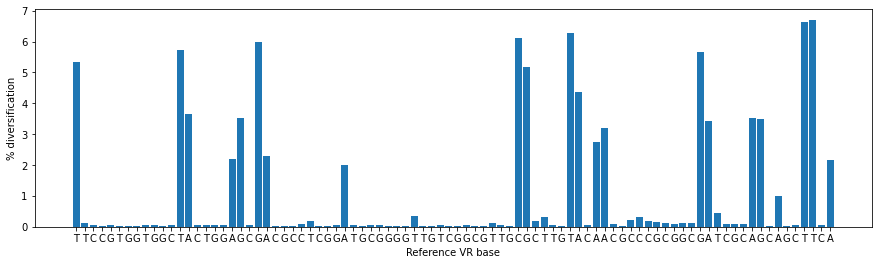

In [12]:
# Total diversification at all TR/VR positions in all reads
sample = 'sample_data/wt_J900'
template = J900_vr # want mismatches to the TR
indices = np.arange(10,9+88+1,1) # same positions shown in Figure 2f (complete 88-nt VR)

data = count_div(sample, template, indices, stacked = False, percent = True, average = False)

plt.figure(figsize=(15,4))
plt.bar(x = np.arange(len(list(data[0]))), height = list(data[0]))
plt.xticks(np.arange(len(list(data[0]))), [str(J900_vr[i]) for i in indices]);
plt.xlabel('Reference VR base');
plt.ylabel('% diversification');

### Diversification at each position in the cDNA

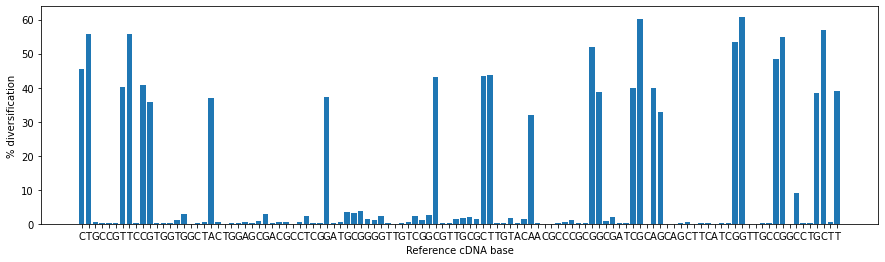

In [13]:
# Total diversification at all cDNA positions
sample = 'sample_data/wt_J902'
template = J902
indices = list(np.arange(4, 116)) # same indices shown in Figure 2g (88-nt VR + td intron remnant)

data = count_div(sample, template, indices, stacked = False, percent = True, average = False)

plt.figure(figsize=(15,4))
plt.bar(x = np.arange(len(list(data[0]))), height = list(data[0]))
plt.xticks(np.arange(len(list(data[0]))), [str(J900_vr[i]) for i in indices]);
plt.xlabel('Reference cDNA base');
plt.ylabel('% diversification');

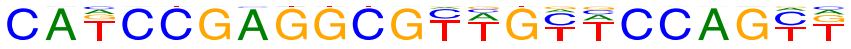

In [17]:
# generate cDNA logo (see Fig 2h)
wt_cnda_seqs = []
for record in SeqIO.parse('sample_data/wt_J902.fasta','fasta'):
    if record.seq.find('N') < 0:
        # append the 5' part of the cDNA (corresponds to 3' end of RNA amplicon)
        wt_cnda_seqs.append(str(record.seq.reverse_complement())[-26:-4])
        
fig, ax = plt.subplots(1,1,figsize=[15,0.65], frameon = False)
wt_cdna_logo = logomaker.Logo(logomaker.alignment_to_matrix(wt_cnda_seqs, to_type = 'probability'),
                              ax = ax, show_spines = False,
                              stack_order = 'small_on_top', vpad = 0.1,
                              width = 0.8, font_name = 'Helvetica', color_scheme = 'classic')
ax.set_xticks([])
ax.set_yticks([]); 

## Contextual diversification <a name="context"></a>
Frame = -1

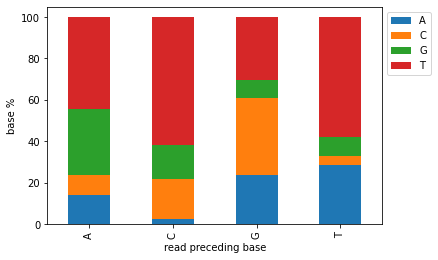

In [102]:
# contextual diversification at AAC codons
sample = 'sample_data/wt_J902'
template = J902
indices = aac1_J902_idx

data = count_context(sample, template, indices)
data = data.convert_dtypes(infer_objects=True)
data.groupby(['read preceding base', 'base'])['%'].describe()['mean'].unstack().plot(kind = 'bar', stacked = True)
plt.legend(bbox_to_anchor=(1, 1));
plt.ylabel('base %');

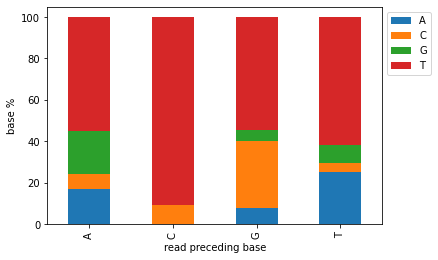

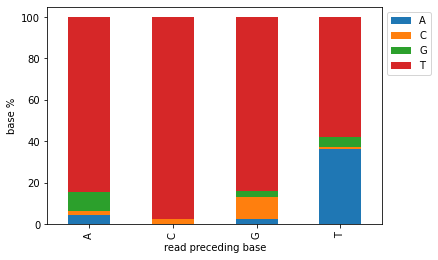

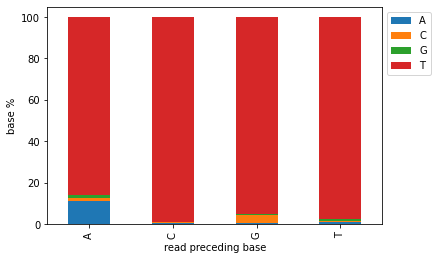

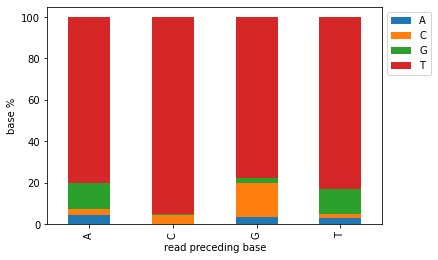

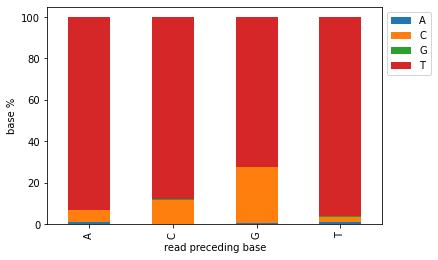

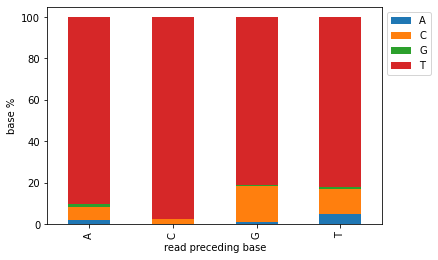

In [37]:
# replicate Fig4g
# contextual diversification at all A positions preceded by a matched base
# this excludes some reads with templated AAs where the preceding base is diversified

samples = ['sample_data/wt_J902', 
           'sample_data/K71A_J902', 
           'sample_data/I184Q_J902',
           'sample_data/I184M_J902', 
           'sample_data/I184S_J902', 
           'sample_data/R73Y_J902']
template = J902
indices = a_J902_idx

for sample in samples:
    data = count_context(sample, template, indices)
    data_match = data[data['match'] == True]
    data_grouped = data_match.groupby(['read preceding base', 'base'])['%'].describe()['mean'].unstack()
    ax = data_grouped.plot(kind='bar', stacked=True)
    ax.legend(bbox_to_anchor=(1, 1));
    ax.set_ylabel('base %');

## Amino acid bias due to contextual diversification <a name="aa"></a>

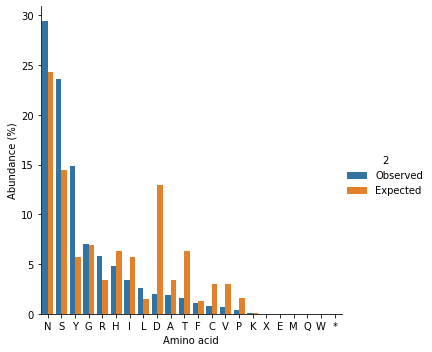

In [21]:
# observed residue distribution
df1 = pd.DataFrame.from_dict(count_residues('sample_data/wt_J902', aac_J902_idx, observed = True),
                             orient = 'index')
# expected residue distribution
df2 = pd.DataFrame.from_dict(count_residues('sample_data/wt_J902', aac_J902_idx, observed = False), 
                       orient = 'index')
ax = sns.catplot(x = 'index', y = 0, hue = 2, data = pd.concat([df1, df2], axis=0).reset_index(), kind = 'bar')
ax.set(xlabel='Amino acid', ylabel='Abundance (%)')